In [2]:
import math
import time
import pickle
import pandas as pd
import numpy as np

In [3]:
import torch
import sklearn

In [4]:
from pyqpanda import *

In [5]:
%matplotlib inline

# 1. Prepare Dadaset

In [6]:
# https://www.kaggle.com/datasets/sumanthvrao/daily-climate-time-series-data

In [7]:
train_path = './../data/DailyDelhiClimateTrain.csv'
test_path = './../data/DailyDelhiClimateTest.csv'

In [8]:
cols = [1,2,3,4]

train = pd.read_csv(train_path, usecols=cols, engine="python")
test = pd.read_csv(test_path, usecols=cols, engine="python")

In [9]:
print(f'len(train)={len(train)}')
print(f'len(test)={len(test)}')

len(train)=1462
len(test)=114


## 1.1 Outlier Detection

### 1.1.1 outlier detection for train

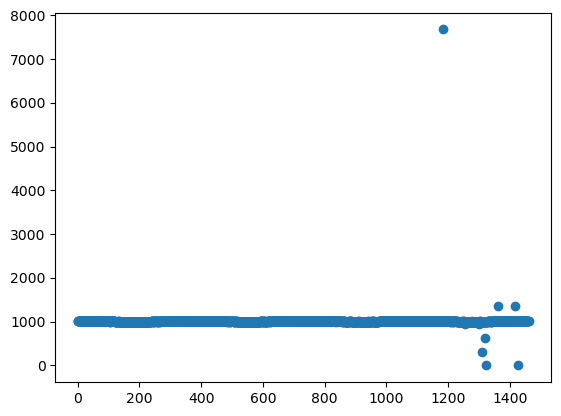

In [10]:
plt.scatter(range(len(train)), train["meanpressure"])

### - remove outliers 

In [11]:
unnormal_num = 0
for i in range(len(train)):
    mp = train.iloc[i][3]
    if mp > 1200 or mp < 950:
        unnormal_num += 1
        train.iloc[i][3] = train.iloc[i + 1][3]
print(f'remove outliers num: {unnormal_num}')

remove outliers num: 9


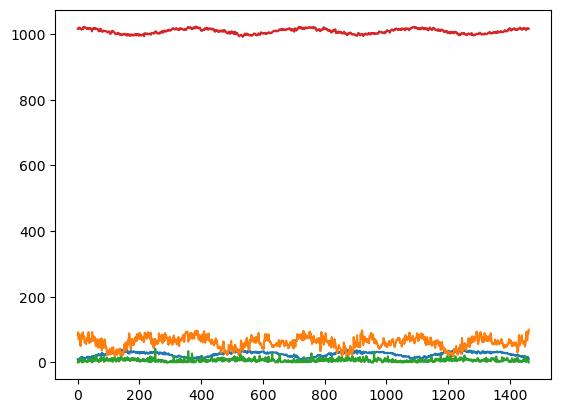

In [12]:
plt.plot(train)

In [13]:
train.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
meantemp,1462.0,25.495521,7.348103,6.000000,18.857143,27.714286,31.305804,38.714286
humidity,1462.0,60.771702,16.769652,13.428571,50.375000,62.625000,72.218750,100.000000
wind_speed,1462.0,6.802209,4.561602,0.000000,3.475000,6.221667,9.238235,42.220000
meanpressure,1462.0,1008.247674,7.437992,991.375000,1001.625000,1008.563492,1014.875000,1023.000000


In [14]:
train[0:1]

,meantemp,humidity,wind_speed,meanpressure
0,10.0,84.5,0.0,1015.666667


### 1.1.2 outlier detection for test

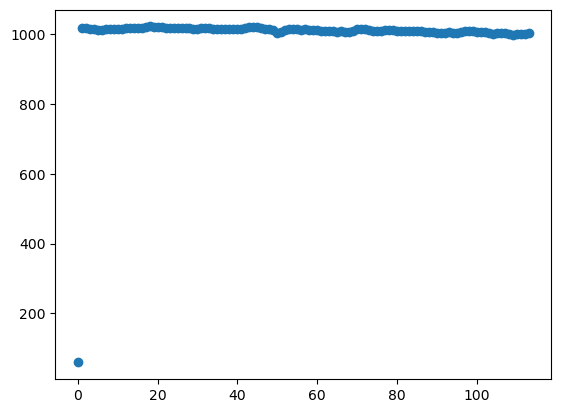

In [15]:
plt.scatter(range(len(test)), test["meanpressure"])

### - remove outliers 

In [16]:
test.iloc[0][3] = test.iloc[1][3]

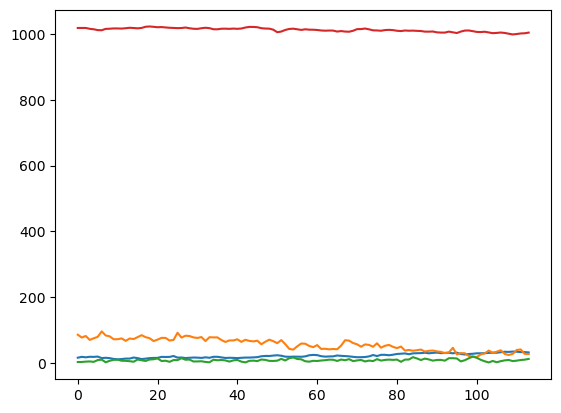

In [17]:
plt.plot(test)

## 1.2 Transfer data to LSTM representation

In [18]:
from sklearn.preprocessing import StandardScaler

In [19]:
def data_process(data, window_size, predict_size):
    scaler = StandardScaler()
    data = scaler.fit_transform(np.array(data).reshape(-1, 1))
    
    data_in = []
    data_out = []
    
    for i in range(data.shape[0] - window_size - predict_size):
        data_in.append(data[i:i + window_size].reshape(1, window_size)[0])
        data_out.append(data[i + window_size:i + window_size + predict_size].reshape(1, predict_size)[0])
        
    data_in = np.array(data_in).reshape(-1, window_size)
    data_out = np.array(data_out).reshape(-1, predict_size)
    
    data_process = {'datain': data_in, 'dataout': data_out}
    
    return data_process, scaler

## 1.3 prepare train/test dataset

In [20]:
features_size = 4
window_size = features_size * 3 # features num * time steps
predict_size = features_size # features

In [21]:
train_processed, train_scaler = data_process(train, window_size, predict_size)
X_train, y_train = train_processed['datain'], train_processed['dataout']

test_processed, test_scaler = data_process(test, window_size, predict_size)
X_test, y_test = test_processed['datain'], test_processed['dataout']

In [22]:
X_train = torch.from_numpy(X_train.astype(np.float32))
X_test = torch.from_numpy(X_test.astype(np.float32))

y_train = torch.from_numpy(y_train.astype(np.float32))
y_test = torch.from_numpy(y_test.astype(np.float32))

### - data loader

In [23]:
import torch.utils.data as Data

train_data = Data.TensorDataset(X_train, y_train)
test_data = Data.TensorDataset(X_test, y_test)

In [24]:
print(f'size of train_data: {len(train_data)}')
print(f'size of test_data: {len(test_data)}')

size of train_data: 5832
size of test_data: 440


In [25]:
train_data[0]

(tensor([-0.6262, -0.4504, -0.6498,  1.7473, -0.6323, -0.4327, -0.6428,  1.7523,
         -0.6329, -0.4445, -0.6389,  1.7543]),
 tensor([-0.6293, -0.4814, -0.6469,  1.7508]))

In [26]:
test_data[0]

(tensor([-0.6067, -0.4426, -0.6376,  1.7437, -0.6006, -0.4629, -0.6372,  1.7437,
         -0.6039, -0.4520, -0.6346,  1.7438]),
 tensor([-0.6001, -0.4797, -0.6333,  1.7377]))

# 2. Quantum Enhanced LSTM

## 2.1 initiate quantum environment

In [27]:
class InitQMachine:
    def __init__(self, qubitsCount, cbitsCount = 0, machineType = QMachineType.CPU):
        self.machine = init_quantum_machine(machineType)
        
        self.qubits = self.machine.qAlloc_many(qubitsCount)
        self.cbits = self.machine.cAlloc_many(cbitsCount)
        
        print(f'Init Quantum Machine with qubits:[{qubitsCount}] / cbits:[{cbitsCount}] Successfully')
    
    def __del__(self):
        destroy_quantum_machine(self.machine)

In [28]:
# maximum qubits size
ctx = InitQMachine(5)

Init Quantum Machine with qubits:[5] / cbits:[0] Successfully


## 2.2 Quantum Layer

### - Tool Functions

In [29]:
def draw(prog, filename=''):
    dir_path = './images/'
    
    if filename != '':
        draw_qprog(prog, 'pic', filename=f'{dir_path}{filename}')

### 2.2.1 Quantum Layer Base

In [30]:
import torch.nn as nn
from torch import Tensor
from torch.nn import Parameter

In [31]:
class QuantumLayerBase(nn.Module):
    def __init__(self, input_size, output_size, *, n_qubits, n_layers = 1, ctx = None):
        super(QuantumLayerBase, self).__init__()
        
        self.data = None # need to input during forward
    
        self.input_size = input_size
        self.output_size = output_size # hidden size, not n_qubits
        
        # quantum infos
        self.n_qubits = n_qubits
        self.n_layers = n_layers
        
        self.ctx = ctx
        self.qubits = ctx.qubits
        self.machine = ctx.machine
        
        # convert quantum input/output to match classical computation
        self.qin = nn.Linear(self.input_size, self.n_qubits)
        self.qout = nn.Linear(self.n_qubits, self.output_size)
        
    @property
    def circuit(self):
        raise NotImplementedError('Should init circuit')

In [32]:
def measure(self):
    HamiZ = [ PauliOperator({f'Z{i}': 1}) for i in range(len(self.qubits)) ]
    res = [ eval(qop(self.circuit, Hami, self.machine, self.qubits))[0,0] for Hami in HamiZ ]
    
    return Parameter(Tensor(res[:self.n_qubits]))

QuantumLayerBase.measure = measure

In [33]:
def forward(self, inputs):
    y_t = self.qin(Parameter(inputs))
    self.data = y_t[0]
    
    return self.qout(self.measure())

QuantumLayerBase.forward = forward

### 2.2.2 Quantum Layer Design

In [34]:
dropout_lock = True

In [35]:
class QuantumLayer(QuantumLayerBase):
    def __init__(self, input_size, output_size, *, n_qubits, degree = 1, n_layers = 1, ctx = None, dropout_rate = 0):
        super(QuantumLayer, self).__init__(input_size, output_size, 
                                         n_qubits = n_qubits, n_layers = n_layers, ctx = ctx)
        
        self.degree = degree
        self.dropout_rate = dropout_rate
        self.angles = Parameter(torch.rand(n_layers + 1, degree, self.n_qubits))
        
    @property
    def qparameters_size(self):
        return self.angles.flatten().size()[0]
        
    @property
    def circuit(self):
        if self.data == None:
            raise ValueError('Need to feed a input data!')
        
        n = self.n_qubits
        q = self.qubits
        x = self.data
        p = self.angles
        degree = self.degree
        
        # quantum gates - must use small case!
        identity = VariationalQuantumGate_I
        h = VariationalQuantumGate_H
        ry = VariationalQuantumGate_RY
        cz = VariationalQuantumGate_CZ
        u = [
            None,
            VariationalQuantumGate_U1,
            VariationalQuantumGate_U2,
            VariationalQuantumGate_U3
        ]
        
        # init variational quantum circuit
        vqc = VariationalQuantumCircuit()

        # in order to use each qubits => when n_qubits < len(ctx.qubits)
        [ vqc.insert(identity(q[i])) for i in range(len(q)) ]
        
        [ vqc.insert( h(q[i]) ) for i in range(n) ]
        [ vqc.insert( ry(q[i], var(x[i] * torch.pi / 2)) ) for i in range(n) ]
        
        for i in range(n):
            for d in range(degree):
                if dropout_lock and np.random.rand() <= self.dropout_rate:
                    p.data[0][d][i] = np.pi
                
            vqc.insert( u[degree](q[i], *[ var(p[0][d][i]) for d in range(degree) ]) )
        
        for layer in range(self.n_layers):
            for i in range(n - 1):
                vqc.insert(cz(q[i], q[i + 1]))
            vqc.insert(cz(q[n - 1], q[0]))
            
            for i in range(n):
                for d in range(degree):
                    if dropout_lock and np.random.rand() <= self.dropout_rate:
                        p.data[layer + 1][d][i] = np.pi
                vqc.insert( u[degree](q[i], *[ var(p[layer + 1][d][i]) for d in range(degree) ]) ) 
        
        return vqc

### 2.2.3 Plot Quantum layer

In [36]:
data = Tensor([[0.1, 0.2, 0.3, 0.4, 0.5]])
layer = QuantumLayer(5, 5, n_qubits=5, n_layers=1, degree=3, dropout_rate=0.3, ctx=ctx)
layer.data = data[0]
vqc = layer.circuit
prog = create_empty_qprog()
prog.insert(vqc.feed())

In [37]:
draw_qprog(prog, 'pic', filename=f'pic/angles_yes')

'null'

## 2.3 Quantum-LSTM

In [38]:
class QLSTMBase(nn.Module):
    def __init__(self, input_size, hidden_size, *, ctx, dropout_rate=0):
        super().__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.ctx = ctx
        self.dropout_rate = dropout_rate
        
    @property
    def qparameters_size(self):
        num = 0
        for attr in dir(self):
            if attr.endswith('_circuit'):
                num += getattr(self, attr).qparameters_size
        return num

In [39]:
def forward(self, inputs, init_states = None):
    sequence_size, batch_size, _ = inputs.size()
    hidden_sequence = []
    
    if init_states == None:
        h_t, c_t = (
            torch.zeros(1, batch_size, self.hidden_size).to(inputs.device),
            torch.zeros(1, batch_size, self.hidden_size).to(inputs.device),
        )
    else:
        h_t, c_t = init_states
    
    return hidden_sequence, (h_t, c_t)

QLSTMBase.forward = forward

### 2.3.1 classical Quantum-LSTM

In [40]:
class QLSTM(QLSTMBase):
    def __init__(self, input_size, hidden_size, *, ctx, dropout_rate=0):
        super().__init__(input_size, hidden_size, ctx = ctx, dropout_rate = dropout_rate)
        
        # Parameters: angles
        #  => Q * (n + 1) * degree
        
        # gates names:  qubits  layers  degree
        # input gate:     5       2       3
        # forget gate:    5       2       3
        # candidate:      5       2       3
        # output gate:    5       2       3
        
        # input gates
        self.input_circuit = QuantumLayer(input_size + hidden_size, hidden_size, 
                                        n_qubits = 5, n_layers = 2, degree = 3, ctx = ctx, dropout_rate = dropout_rate) # 45
        # forget gates
        self.forget_circuit = QuantumLayer(input_size + hidden_size, hidden_size, 
                                         n_qubits = 5, n_layers = 2, degree = 3, ctx = ctx, dropout_rate = dropout_rate) # 45
        # candidate
        self.candidate_circuit = QuantumLayer(input_size + hidden_size, hidden_size, 
                                       n_qubits = 5, n_layers = 2, degree = 3, ctx = ctx, dropout_rate = dropout_rate) # 45
        # output gates
        self.output_circuit = QuantumLayer(input_size + hidden_size, hidden_size, 
                                         n_qubits = 5, n_layers = 2, degree = 3, ctx = ctx, dropout_rate = dropout_rate) # 45
        
    def forward(self, inputs, init_states = None):
        hidden_sequence, (h_t, c_t) = super(QLSTM, self).forward(inputs, init_states)

        for t in range(inputs.size()[0]):
            x_t = inputs[t, :, :]
            v_t = torch.cat((h_t[0], x_t), dim = 1)

            # input gates
            i_t = torch.sigmoid(self.input_circuit(v_t))
            # forget gates
            f_t = torch.sigmoid(self.forget_circuit(v_t))
            # candidate for cell state update
            g_t = torch.tanh(self.candidate_circuit(v_t))
            c_t = (f_t * c_t) + (i_t * g_t)

            # output gates
            o_t = torch.sigmoid(self.output_circuit(v_t))
            # update output ht
            h_t = o_t * (torch.tanh(c_t))

            hidden_sequence.append(h_t)

        # reshape hidden_seq p/ retornar
        #
        # [tensor([[[0.0444, ...]]] => tensor([[[0.0444, ...]]]
        # 
        hidden_sequence = torch.cat(hidden_sequence, dim = 0)

        return hidden_sequence, (h_t, c_t)

### 2.3.2 adjusted classical QLSTM

In [41]:
class AdjustedQLSTM(QLSTMBase):
    def __init__(self, input_size, hidden_size, *, ctx, dropout_rate = 0):
        super().__init__(input_size, hidden_size, ctx = ctx, dropout_rate = dropout_rate)
        
        # gates names:  qubits  layers  degree
        # input gate:     4       2       3
        # forget gate:    5       2       3
        # candidate:      4       1       3
        # output gate:    3       2       2
        
        # input gates
        self.input_circuit = QuantumLayer(input_size + hidden_size, hidden_size, 
                                        n_qubits = 4, n_layers = 2, degree = 3, ctx = ctx, dropout_rate = dropout_rate) # 36
        # forget gates
        self.forget_circuit = QuantumLayer(input_size + hidden_size, hidden_size, 
                                         n_qubits = 5, n_layers = 2, degree = 3, ctx = ctx, dropout_rate = dropout_rate) # 45
        # candidate
        self.candidate_circuit = QuantumLayer(input_size + hidden_size, hidden_size, 
                                       n_qubits = 4, n_layers = 1, degree = 3, ctx = ctx, dropout_rate = dropout_rate) # 24
        # output gates
        self.output_circuit = QuantumLayer(input_size + hidden_size, hidden_size, 
                                         n_qubits = 3, n_layers = 2, degree = 2, ctx = ctx, dropout_rate = dropout_rate) # 18
        
    def forward(self, inputs, init_states = None):
        hidden_sequence, (h_t, c_t) = super(AdjustedQLSTM, self).forward(inputs, init_states)

        for t in range(inputs.size()[0]):
            x_t = inputs[t, :, :]
            v_t = torch.cat((h_t[0], x_t), dim = 1)

            # input gates
            i_t = torch.sigmoid(self.input_circuit(v_t))
            # forget gates
            f_t = torch.sigmoid(self.forget_circuit(v_t))
            # candidate for cell state update
            g_t = torch.tanh(self.candidate_circuit(v_t))
            c_t = (f_t * c_t) + (i_t * g_t)

            # output gates
            o_t = torch.sigmoid(self.output_circuit(v_t))
            # update output ht
            h_t = o_t * (torch.tanh(c_t))

            hidden_sequence.append(h_t)

        hidden_sequence = torch.cat(hidden_sequence, dim = 0)

        return hidden_sequence, (h_t, c_t)

### 2.3.3 peephole QLSTM

In [42]:
class PeepholeQLSTM(QLSTMBase):
    def __init__(self, input_size, hidden_size, *, ctx, dropout_rate = 0):
        super().__init__(input_size, hidden_size, ctx = ctx, dropout_rate = dropout_rate)
        
        # gates names:  qubits  layers  degree
        # input gate:     4       2       3
        # forget gate:    5       2       3
        # candidate:      4       1       3
        # output gate:    3       2       2
        
        # input gates
        self.input_circuit = QuantumLayer(input_size + hidden_size, hidden_size, 
                                        n_qubits = 4, n_layers = 2, degree = 3, ctx = ctx, dropout_rate = dropout_rate) # 36
        # forget gates
        self.forget_circuit = QuantumLayer(input_size + hidden_size, hidden_size, 
                                         n_qubits = 5, n_layers = 2, degree = 3, ctx = ctx, dropout_rate = dropout_rate) # 45
        # candidate
        self.candidate_circuit = QuantumLayer(input_size + hidden_size, hidden_size, 
                                       n_qubits = 4, n_layers = 1, degree = 3, ctx = ctx, dropout_rate = dropout_rate) # 24
        # output gates
        self.output_circuit = QuantumLayer(input_size + hidden_size, hidden_size, 
                                         n_qubits = 3, n_layers = 2, degree = 2, ctx = ctx, dropout_rate = dropout_rate) # 18
        
    def forward(self, inputs, init_states = None):
        hidden_sequence, (h_t, c_t) = super(PeepholeQLSTM, self).forward(inputs, init_states)

        for t in range(inputs.size()[0]):
            x_t = inputs[t, :, :]
            v_t = torch.cat((c_t[0], x_t), dim = 1)
            
            # input gates
            i_t = torch.sigmoid(self.input_circuit(v_t))
            # forget gates
            f_t = torch.sigmoid(self.forget_circuit(v_t))
            # candidate for cell state update
            g_t = torch.tanh(self.candidate_circuit(v_t))
            c_t = (f_t * c_t) + (i_t * g_t)
            
            # output gates
            o_t = torch.sigmoid(self.output_circuit(v_t))
            # update output ht
            h_t = o_t * (torch.tanh(c_t))

            hidden_sequence.append(h_t)

        hidden_sequence = torch.cat(hidden_sequence, dim = 0)

        return hidden_sequence, (h_t, c_t)

### 2.3.4 Coupled Input and Forget gates QLSTM

In [43]:
class CIFGQLSTM(QLSTMBase):
    def __init__(self, input_size, hidden_size, *, ctx, dropout_rate = 0):
        super().__init__(input_size, hidden_size, ctx = ctx, dropout_rate = dropout_rate)
        
        # gates names:  qubits  layers  degree
        # coupled IF:     5       2       3
        # candidate:      4       2       3
        # output gate:    3       2       2
        
        # Coupled Input and Forget gate
        self.coupled_IF_circuit = QuantumLayer(input_size + hidden_size, hidden_size, 
                                         n_qubits = 5, n_layers = 2, degree = 3, ctx = ctx, dropout_rate = dropout_rate) # 30
        # candidate for cell state update
        self.candidate_circuit = QuantumLayer(input_size + hidden_size, hidden_size, 
                                       n_qubits = 4, n_layers = 2, degree = 3, ctx = ctx, dropout_rate = dropout_rate) # 24
        # output gates
        self.output_circuit = QuantumLayer(input_size + hidden_size, hidden_size, 
                                         n_qubits = 3, n_layers = 2, degree = 2, ctx = ctx, dropout_rate = dropout_rate) # 12
        
    def forward(self, inputs, init_states = None):
        hidden_sequence, (h_t, c_t) = super(CIFGQLSTM, self).forward(inputs, init_states)

        for t in range(inputs.size()[0]):
            x_t = inputs[t, :, :]
            v_t = torch.cat((h_t[0], x_t), dim = 1)
            
            # coupled input and forget gate
            f_t = torch.sigmoid(self.coupled_IF_circuit(v_t))
            # candidate for cell state update
            g_t = torch.tanh(self.candidate_circuit(v_t))
            c_t = (f_t * c_t) + ((1 - f_t) * g_t)
            
            # output gates
            o_t = torch.sigmoid(self.output_circuit(v_t))
            # update output ht
            h_t = o_t * (torch.tanh(c_t))

            hidden_sequence.append(h_t)

        hidden_sequence = torch.cat(hidden_sequence, dim = 0)

        return hidden_sequence, (h_t, c_t)

### 2.3.5 Recurrent Gate Units - QGRU

In [44]:
class QGRU(QLSTMBase):
    def __init__(self, input_size, hidden_size, *, ctx, dropout_rate = 0):
        super().__init__(input_size, hidden_size, ctx = ctx, dropout_rate = dropout_rate)
        
        # gates names:  qubits  layers  degree
        # update gate:     5       1       3
        # candidate:       4       1       3
        # reset gate:      3       1       2
        
        # update gates
        self.update_circuit = QuantumLayer(input_size + hidden_size, hidden_size, 
                                         n_qubits = 5, n_layers = 1, degree = 3, ctx = ctx, dropout_rate = dropout_rate) # 45
        # candidate for hidden state update
        self.candidate_circuit = QuantumLayer(input_size + hidden_size, hidden_size, 
                                       n_qubits = 4, n_layers = 1, degree = 3, ctx = ctx, dropout_rate = dropout_rate) # 36
        # reset gates
        self.reset_circuit = QuantumLayer(input_size + hidden_size, hidden_size, 
                                         n_qubits = 3, n_layers = 1, degree = 2, ctx = ctx, dropout_rate = dropout_rate) # 18
        
    def forward(self, inputs, init_states = None):
        hidden_sequence, (h_t, c_t) = super(QGRU, self).forward(inputs, init_states)

        for t in range(inputs.size()[0]):
            x_t = inputs[t, :, :]
            v_t = torch.cat((h_t[0], x_t), dim = 1)
            
            # update gates
            z_t = torch.sigmoid(self.update_circuit(v_t))
            # reset gates
            r_t = torch.sigmoid(self.reset_circuit(v_t))
        
            v_hat_t = torch.cat(((r_t * h_t)[0], x_t), dim = 1)
            # candidate for hidden state update
            g_t = torch.tanh(self.candidate_circuit(v_hat_t))
            h_t = (z_t * g_t) + (1 - z_t) * h_t 

            hidden_sequence.append(h_t)

        hidden_sequence = torch.cat(hidden_sequence, dim = 0)

        return hidden_sequence, (h_t, c_t)

### - QLSTMs Map

In [45]:
QLSTMMap = {
    'classical': ('QLSTM', QLSTM),
    'adjusted': ('QLSTM(adjusted)', AdjustedQLSTM),
    'peephole': ('peephole QLSTM', PeepholeQLSTM),
    'CIFG': ('CIFG-QLSTM', CIFGQLSTM),
    'GRU': ('QGRU', QGRU)
}

## 2.4 Stacked QLSTM

In [46]:
from collections import OrderedDict

class StackedQLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, *, num_layers = 1, ctx = None, mode = 'classical', dropout_rate = 0):
        super().__init__()
        
        label, qlstm = QLSTMMap.get(mode)
        self.qlstms = nn.Sequential(OrderedDict([
            (f'{label} {i + 1}', qlstm(input_size if i == 0 else hidden_size , hidden_size, ctx = ctx, dropout_rate = dropout_rate)) 
                for i in range(num_layers)
        ]))

    def forward(self, inputs, parameters = None):
        outputs = None
        
        for i, qlstm in enumerate(self.qlstms):
            if i != 0:
                inputs = outputs
            
            outputs, parameters = qlstm(inputs, parameters)
        
        return outputs, parameters

# 3. Quantum Model and Train

In [47]:
class QModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_output, *, num_layers = 1, ctx = None, mode = 'classical', dropout_rate = 0):
        super(QModel, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.mode = mode
        
        self.qlstm = StackedQLSTM(input_size, hidden_size, 
                                  num_layers = num_layers, ctx = ctx, mode = mode, dropout_rate = dropout_rate)
        self.predict = nn.Linear(hidden_size, num_output)

    def forward(self, x):
        x = x.unsqueeze(0)
        
        # sequence lenth , batch_size, features length
        # 
        h0 = torch.zeros(1, x.size(1), self.hidden_size)
        c0 = torch.zeros(1, x.size(1), self.hidden_size)
        
        out, _ = self.qlstm(x, (h0, c0))
        out = self.predict(out[0])
        
        return out

## 3.1 train QModel

In [48]:
from torch.utils.data import RandomSampler

def train_model(model, datas, batch_size, *, loss_func, optimizer, epoch = 50, early_stop = False):
    losses = []
    sampler = RandomSampler(datas, num_samples = batch_size)
    
    last_loss = 0.0
    for step in range(epoch):
        train_loss = 0.0
        
        for index in sampler:
            batch_x, batch_y = datas[index][0], datas[index][1]
            b_x = batch_x.unsqueeze(0)
            b_y = batch_y.unsqueeze(0)
            
            output = model(b_x)

            loss = loss_func(output, b_y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        loss = train_loss / batch_size
        if early_stop and abs(loss - train_loss) < 1e-4:
            break
            
        last_loss = loss
        
        print(f'Epoch {step + 1}/{epoch}: Loss: {loss}')
        losses.append(loss)
    
    return losses

## 3.2 Evaluate Model

In [49]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

def MAE_naive(actuals, predicteds):
    n = len(actuals)
    err = 0.0
    
    for i in range(1, n):
        err += np.abs(actuals[i] - actuals[i - 1])
    return err / (n - 1)

def calculate_accuarcy(model, X_test, y_test, scaler=test_scaler):
    n = len(X_test)
    
    actuals = []
    predicteds = []
    
    for i in range(0, n, predict_size):
        actual = scaler.inverse_transform(y_test[i:i+1].data)
        actuals.append(np.array(actual[0]))
        predicted = scaler.inverse_transform(model(X_test[i:i+1]).data)
        predicteds.append(np.array(predicted[0]))
    
    actuals = np.array(actuals)
    predicteds = np.array(predicteds)
    
    mae = mean_absolute_error(actuals, predicteds)
    mase = mae / MAE_naive(actuals.flatten(), predicteds.flatten())
    mape = mean_absolute_percentage_error(actuals, predicteds)
    mse = mean_squared_error(actuals, predicteds)
    rmse = mse ** 0.5
    
    return np.array([(1 - mase) * 100, rmse, mse, mae, mape])

## 3.3 Train Model

In [50]:
features_size = 4
window_size = features_size * 3 # 
predict_size = features_size # features

input_size = window_size
num_output = predict_size

hidden_size = 32
num_layers = 2

In [50]:
# learning rate:
# classical: 0.0035
# adjusted: 0.0028
# peephole: 0.0027
# CIFG: 0.004
# GRU: 0.0035

In [51]:
best_score = 0
best_model = None
count = 1
for dropout_rate in [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.001, 0.002, 0.003, 0.005, 0.01, 0.02, 0.03, 0.05]:
    print('-' * 20)
    print('count:', count)
    print('selected hidden_size: ', hidden_size)
    print('selected num_layers: ', num_layers)
    print('selected dropout_rate: ', dropout_rate)
    count += 1
    dropout_lock = True
    qmodel = QModel(input_size, hidden_size, num_output, 
        num_layers = num_layers, ctx = ctx, mode='adjusted', dropout_rate=dropout_rate)
    optimizer = torch.optim.AdamW(qmodel.parameters(), lr = 0.0028)
    loss_func = nn.MSELoss()

    losses = train_model(qmodel, train_data, batch_size=20,          
                   loss_func = loss_func, optimizer = optimizer, epoch = 100)
    dropout_lock = False
    score = calculate_accuarcy(qmodel, X_test, y_test).numpy()
    if score > best_score:
        best_score = score
        best_model = qmodel
        best_parameters = {
            'hidden_size': hidden_size,
            'num_layers': num_layers,
            'dropout_rate': dropout_rate
        }
    print()

print("Best score: ", best_score)
print("Best parameters: ", best_parameters)

--------------------
count: 1
selected hidden_size:  32
selected num_layers:  2
selected dropout_rate:  0.0001
Epoch 1/100: Loss: 0.9792974799871444
Epoch 2/100: Loss: 0.9606465220451355
Epoch 3/100: Loss: 0.9353862315416336
Epoch 4/100: Loss: 0.8940511018037796
Epoch 5/100: Loss: 0.9248705536127091
Epoch 6/100: Loss: 0.7952437847852707
Epoch 7/100: Loss: 0.7658496648073196
Epoch 8/100: Loss: 0.6475878834724427
Epoch 9/100: Loss: 0.5897083833813668
Epoch 10/100: Loss: 0.45471456795930865
Epoch 11/100: Loss: 0.4402692951261997
Epoch 12/100: Loss: 0.3513990730047226
Epoch 13/100: Loss: 0.28561022244393824
Epoch 14/100: Loss: 0.289244981855154
Epoch 15/100: Loss: 0.17600336223840712
Epoch 16/100: Loss: 0.1660008942708373
Epoch 17/100: Loss: 0.14566541612148284
Epoch 18/100: Loss: 0.11985830422490835
Epoch 19/100: Loss: 0.05266022738069296
Epoch 20/100: Loss: 0.03247259252239019
Epoch 21/100: Loss: 0.03421824882971123
Epoch 22/100: Loss: 0.014342112059239298
Epoch 23/100: Loss: 0.010173793

Epoch 95/100: Loss: 0.0016571774762269343
Epoch 96/100: Loss: 0.001274918382659962
Epoch 97/100: Loss: 0.000898349893395789
Epoch 98/100: Loss: 0.0005748509114710032
Epoch 99/100: Loss: 0.000632300978031708
Epoch 100/100: Loss: 0.0013873392628738657

--------------------
count: 3
selected hidden_size:  32
selected num_layers:  2
selected dropout_rate:  0.0003
Epoch 1/100: Loss: 1.0007729470729827
Epoch 2/100: Loss: 0.9702462285757065
Epoch 3/100: Loss: 0.9074630796909332
Epoch 4/100: Loss: 0.9112751573324204
Epoch 5/100: Loss: 0.8902801364660263
Epoch 6/100: Loss: 0.8282651305198669
Epoch 7/100: Loss: 0.7460616588592529
Epoch 8/100: Loss: 0.6354434862732887
Epoch 9/100: Loss: 0.5509909898042679
Epoch 10/100: Loss: 0.43656118363142016
Epoch 11/100: Loss: 0.3412603996694088
Epoch 12/100: Loss: 0.3472663383930922
Epoch 13/100: Loss: 0.30503359287977216
Epoch 14/100: Loss: 0.319686758518219
Epoch 15/100: Loss: 0.22827285192906857
Epoch 16/100: Loss: 0.29380685947835444
Epoch 17/100: Loss: 

Epoch 89/100: Loss: 0.00030355493199749615
Epoch 90/100: Loss: 0.0003579487061870168
Epoch 91/100: Loss: 0.00034456495777703824
Epoch 92/100: Loss: 0.0005291378525726032
Epoch 93/100: Loss: 0.0003963691598983132
Epoch 94/100: Loss: 0.0005942927477917692
Epoch 95/100: Loss: 0.00040328756390408673
Epoch 96/100: Loss: 0.00041036324510059787
Epoch 97/100: Loss: 0.0003159003480504907
Epoch 98/100: Loss: 0.00031080381650099297
Epoch 99/100: Loss: 0.0003972908274590736
Epoch 100/100: Loss: 0.00047481390174652915

--------------------
count: 5
selected hidden_size:  32
selected num_layers:  2
selected dropout_rate:  0.0005
Epoch 1/100: Loss: 1.005953586101532
Epoch 2/100: Loss: 1.008610188961029
Epoch 3/100: Loss: 0.9584341734647751
Epoch 4/100: Loss: 0.8927394658327102
Epoch 5/100: Loss: 0.8695585191249847
Epoch 6/100: Loss: 0.8356432020664215
Epoch 7/100: Loss: 0.6789845153689384
Epoch 8/100: Loss: 0.48056678734719754
Epoch 9/100: Loss: 0.6760386838577688
Epoch 10/100: Loss: 0.63210019189864

Epoch 85/100: Loss: 0.0017496553322416731
Epoch 86/100: Loss: 0.0010552251798799262
Epoch 87/100: Loss: 0.002277115860488266
Epoch 88/100: Loss: 0.0017672371977823786
Epoch 89/100: Loss: 0.12205624361558876
Epoch 90/100: Loss: 0.01359972048085183
Epoch 91/100: Loss: 0.05684650681214407
Epoch 92/100: Loss: 0.007254951365757734
Epoch 93/100: Loss: 0.004559412043454359
Epoch 94/100: Loss: 0.003375246662835707
Epoch 95/100: Loss: 0.0012678109836997465
Epoch 96/100: Loss: 0.0008712879272934515
Epoch 97/100: Loss: 0.0009046002618561033
Epoch 98/100: Loss: 0.0010709523505738616
Epoch 99/100: Loss: 0.00045334984824876303
Epoch 100/100: Loss: 0.0009371334883326199

--------------------
count: 7
selected hidden_size:  32
selected num_layers:  2
selected dropout_rate:  0.002
Epoch 1/100: Loss: 1.0348535984754563
Epoch 2/100: Loss: 1.0088209539651871
Epoch 3/100: Loss: 0.9718853563070298
Epoch 4/100: Loss: 0.9239081531763077
Epoch 5/100: Loss: 0.9245913118124008
Epoch 6/100: Loss: 0.89292844831943

Epoch 82/100: Loss: 0.00260234846136882
Epoch 83/100: Loss: 0.001073608663136838
Epoch 84/100: Loss: 0.01966401178797241
Epoch 85/100: Loss: 0.002964802830865665
Epoch 86/100: Loss: 0.0005972252620267682
Epoch 87/100: Loss: 0.002049006059041858
Epoch 88/100: Loss: 0.0011641362274531276
Epoch 89/100: Loss: 0.0067642572732438564
Epoch 90/100: Loss: 0.0017057372875569853
Epoch 91/100: Loss: 0.013080556965360302
Epoch 92/100: Loss: 0.004493867544806562
Epoch 93/100: Loss: 0.0020502127070358258
Epoch 94/100: Loss: 0.018929173963442736
Epoch 95/100: Loss: 0.0017593268581549636
Epoch 96/100: Loss: 0.0020117564003157896
Epoch 97/100: Loss: 0.0035388988408158184
Epoch 98/100: Loss: 0.00369750856916653
Epoch 99/100: Loss: 0.04079060212970944
Epoch 100/100: Loss: 0.002441823967092205

--------------------
count: 9
selected hidden_size:  32
selected num_layers:  2
selected dropout_rate:  0.005
Epoch 1/100: Loss: 0.9898847877979279
Epoch 2/100: Loss: 0.9460822075605393
Epoch 3/100: Loss: 0.99398657

Epoch 80/100: Loss: 0.009409954072907567
Epoch 81/100: Loss: 0.009238444664515556
Epoch 82/100: Loss: 0.054394043603679165
Epoch 83/100: Loss: 0.01404611101024784
Epoch 84/100: Loss: 0.05572434011264704
Epoch 85/100: Loss: 0.027584119967650624
Epoch 86/100: Loss: 0.024978954036487266
Epoch 87/100: Loss: 0.09948421376757324
Epoch 88/100: Loss: 0.11662622739386279
Epoch 89/100: Loss: 0.08508213949389756
Epoch 90/100: Loss: 0.021591523534152657
Epoch 91/100: Loss: 0.01217355084954761
Epoch 92/100: Loss: 0.01571742925152648
Epoch 93/100: Loss: 0.005140182509785518
Epoch 94/100: Loss: 0.0035335760720045075
Epoch 95/100: Loss: 0.11271260535577313
Epoch 96/100: Loss: 0.03227041864884086
Epoch 97/100: Loss: 0.006830558653746266
Epoch 98/100: Loss: 0.004847569894627668
Epoch 99/100: Loss: 0.0020831087151236714
Epoch 100/100: Loss: 0.003519389995926758

--------------------
count: 11
selected hidden_size:  32
selected num_layers:  2
selected dropout_rate:  0.02
Epoch 1/100: Loss: 0.9788655549287

Epoch 78/100: Loss: 0.01798242777440464
Epoch 79/100: Loss: 0.013562807050766424
Epoch 80/100: Loss: 0.017839403919060713
Epoch 81/100: Loss: 0.004136527264927281
Epoch 82/100: Loss: 0.005245239779469557
Epoch 83/100: Loss: 0.01237301706278231
Epoch 84/100: Loss: 0.014925573303480632
Epoch 85/100: Loss: 0.006322446654667147
Epoch 86/100: Loss: 0.01132981125410879
Epoch 87/100: Loss: 0.014755806321045385
Epoch 88/100: Loss: 0.01630245507694781
Epoch 89/100: Loss: 0.010741374775898293
Epoch 90/100: Loss: 0.015211817811359652
Epoch 91/100: Loss: 0.006351055135019124
Epoch 92/100: Loss: 0.01699959056568332
Epoch 93/100: Loss: 0.0054869651394255925
Epoch 94/100: Loss: 0.016452542773913593
Epoch 95/100: Loss: 0.01665731497851084
Epoch 96/100: Loss: 0.012135061863227747
Epoch 97/100: Loss: 0.021643703812151215
Epoch 98/100: Loss: 0.004113686093478464
Epoch 99/100: Loss: 0.012082442127575633
Epoch 100/100: Loss: 0.007153809945157264

--------------------
count: 13
selected hidden_size:  32
sel

In [53]:
best_score

array(0.9822689, dtype=float32)

In [51]:
epoch = 10
acc, rmse, mse, mae, mape = 0, 0, 0, 0, 0
for i in range(epoch):
    dropout_lock = True
    qmodel = QModel(input_size, hidden_size, num_output, 
                    num_layers = num_layers, ctx = ctx, mode='classical', dropout_rate = 0.001)
    optimizer = torch.optim.Adam(qmodel.parameters(), lr = 0.0015)
    loss_func = nn.MSELoss()

    start = time.time()
    losses = train_model(qmodel, train_data, batch_size=20,          
                   loss_func = loss_func, optimizer = optimizer, epoch = 200, early_stop=True)
    end = time.time()

    print(f'time costs: {end - start}')

    dropout_lock = False
    results = calculate_accuarcy(qmodel, X_test, y_test)
    acc += results[0]
    rmse += results[1]
    mse += results[2]
    mae += results[3]
    mape += results[4]

    print(results)

print('mean acc: ', acc / epoch)
print('mean rmse: ', rmse / epoch)
print('mean mse: ', mse / epoch)
print('mean mae: ', mae / epoch)
print('mean mape: ', mape / epoch)

Epoch 1/200: Loss: 1.0722543865442276
Epoch 2/200: Loss: 1.0066252380609513
Epoch 3/200: Loss: 1.0310653507709504
Epoch 4/200: Loss: 1.020116963982582
Epoch 5/200: Loss: 0.9854023933410645
Epoch 6/200: Loss: 0.9949258714914322
Epoch 7/200: Loss: 1.0081254214048385
Epoch 8/200: Loss: 1.0017366319894792
Epoch 9/200: Loss: 0.9906420856714249
Epoch 10/200: Loss: 0.982147079706192
Epoch 11/200: Loss: 1.0078958243131637
Epoch 12/200: Loss: 0.9555333197116852
Epoch 13/200: Loss: 1.0104680985212326
Epoch 14/200: Loss: 0.9549245566129685
Epoch 15/200: Loss: 0.9646935403347016
Epoch 16/200: Loss: 0.929891762137413
Epoch 17/200: Loss: 0.9071144580841064
Epoch 18/200: Loss: 0.8681044429540634
Epoch 19/200: Loss: 0.8769071608781814
Epoch 20/200: Loss: 0.8399729937314987
Epoch 21/200: Loss: 0.8730558663606643
Epoch 22/200: Loss: 0.8123174548149109
Epoch 23/200: Loss: 0.7931818664073944
Epoch 24/200: Loss: 0.80475914478302
Epoch 25/200: Loss: 0.6796054944396019
Epoch 26/200: Loss: 0.7231450557708741


Epoch 197/200: Loss: 0.0006884448237542528
Epoch 198/200: Loss: 0.00043823893893204515
Epoch 199/200: Loss: 0.00037832728594366927
Epoch 200/200: Loss: 0.0006010763745507575
time costs: 3492.414405822754
[98.79735271  8.14105574 66.27678855  6.23384428  0.25636215]
Epoch 1/200: Loss: 1.0336912125349045
Epoch 2/200: Loss: 1.0038621991872787
Epoch 3/200: Loss: 1.0007729470729827
Epoch 4/200: Loss: 0.9911096453666687
Epoch 5/200: Loss: 1.000907564163208
Epoch 6/200: Loss: 1.0065500169992447
Epoch 7/200: Loss: 1.0255460739135742
Epoch 8/200: Loss: 0.9935944885015487
Epoch 9/200: Loss: 0.9660867482423783
Epoch 10/200: Loss: 0.9682745695114136
Epoch 11/200: Loss: 0.979214683175087
Epoch 12/200: Loss: 0.9771888285875321
Epoch 13/200: Loss: 0.9619213908910751
Epoch 14/200: Loss: 0.9401252865791321
Epoch 15/200: Loss: 0.9361094981431961
Epoch 16/200: Loss: 0.9020375430583953
Epoch 17/200: Loss: 0.8991124987602234
Epoch 18/200: Loss: 0.8797226816415786
Epoch 19/200: Loss: 0.8735232949256897
Epoc

Epoch 192/200: Loss: 0.00040037516882875936
Epoch 193/200: Loss: 0.0002406341229288955
Epoch 194/200: Loss: 0.00036342925186545473
Epoch 195/200: Loss: 0.00037488439920707606
Epoch 196/200: Loss: 0.0004610309586496442
Epoch 197/200: Loss: 0.0005194473176743486
Epoch 198/200: Loss: 0.0004447139021067414
Epoch 199/200: Loss: 0.0003806264615377586
Epoch 200/200: Loss: 0.0003008807497735688
time costs: 1572.407198190689
[98.79218945  8.89012359 79.03429743  6.26060768  0.36953305]
Epoch 1/200: Loss: 1.0074389368295669
Epoch 2/200: Loss: 0.9918948858976364
Epoch 3/200: Loss: 0.9738332897424697
Epoch 4/200: Loss: 1.0266530156135558
Epoch 5/200: Loss: 1.0003320962190627
Epoch 6/200: Loss: 0.9991135895252228
Epoch 7/200: Loss: 1.0196909248828887
Epoch 8/200: Loss: 0.9640911132097244
Epoch 9/200: Loss: 0.9790079385042191
Epoch 10/200: Loss: 0.9370558232069015
Epoch 11/200: Loss: 0.9456978976726532
Epoch 12/200: Loss: 0.9300296068191528
Epoch 13/200: Loss: 0.9562271237373352
Epoch 14/200: Loss: 

Epoch 186/200: Loss: 0.0003785672261074069
Epoch 187/200: Loss: 0.00023570157763970202
Epoch 188/200: Loss: 0.00043236003730271475
Epoch 189/200: Loss: 0.0003926012932424783
Epoch 190/200: Loss: 0.0005255003074125852
Epoch 191/200: Loss: 0.00048302279210474806
Epoch 192/200: Loss: 0.0004440075093953055
Epoch 193/200: Loss: 0.00044457571912062124
Epoch 194/200: Loss: 0.00042052566859638316
Epoch 195/200: Loss: 0.0007198776798759354
Epoch 196/200: Loss: 0.00047264689128496685
Epoch 197/200: Loss: 0.0005756523214586196
Epoch 198/200: Loss: 0.0005899593561480287
Epoch 199/200: Loss: 0.0005159347390872426
Epoch 200/200: Loss: 0.0006238027854124084
time costs: 1712.3279452323914
[98.59297974  9.77374683 95.52612712  7.29319831  0.26859832]
Epoch 1/200: Loss: 0.9903054893016815
Epoch 2/200: Loss: 0.9744001477956772
Epoch 3/200: Loss: 0.9896652042865753
Epoch 4/200: Loss: 1.043299239873886
Epoch 5/200: Loss: 1.015221282839775
Epoch 6/200: Loss: 1.018333226442337
Epoch 7/200: Loss: 0.9895227044

Epoch 179/200: Loss: 0.00035185914566682186
Epoch 180/200: Loss: 0.00028321063946350477
Epoch 181/200: Loss: 0.0004908616578177316
Epoch 182/200: Loss: 0.00035148049573763274
Epoch 183/200: Loss: 0.00034015278070000934
Epoch 184/200: Loss: 0.00029821187436027683
Epoch 185/200: Loss: 0.0003233291172364261
Epoch 186/200: Loss: 0.0004927301524730865
Epoch 187/200: Loss: 0.0003804587868216913
Epoch 188/200: Loss: 0.0003687993614221341
Epoch 189/200: Loss: 0.00036004935882374414
Epoch 190/200: Loss: 0.00027932547054660973
Epoch 191/200: Loss: 0.0005154866088560084
Epoch 192/200: Loss: 0.0003145961800328223
Epoch 193/200: Loss: 0.00021322407774277964
Epoch 194/200: Loss: 0.0002871076737392286
Epoch 195/200: Loss: 0.00039011270764603977
Epoch 196/200: Loss: 0.00035873080832971027
Epoch 197/200: Loss: 0.00040670356902410275
Epoch 198/200: Loss: 0.00023889933795544492
Epoch 199/200: Loss: 0.00033944169445021544
Epoch 200/200: Loss: 0.00029651302356796804
time costs: 1767.0501036643982
[98.79314

Epoch 172/200: Loss: 0.00039397550212925123
Epoch 173/200: Loss: 0.00030352854291777477
Epoch 174/200: Loss: 0.0004518365133662883
Epoch 175/200: Loss: 0.00028425538694136775
Epoch 176/200: Loss: 0.00020140119693223824
Epoch 177/200: Loss: 0.00045188188887550494
Epoch 178/200: Loss: 0.00034633373561518963
Epoch 179/200: Loss: 0.0004232802372825972
Epoch 180/200: Loss: 0.0003916910356565495
Epoch 181/200: Loss: 0.000362336701618915
Epoch 182/200: Loss: 0.0002813652661643573
Epoch 183/200: Loss: 0.0003105159379629185
Epoch 184/200: Loss: 0.00042882625675702004
Epoch 185/200: Loss: 0.0004863489506533369
Epoch 186/200: Loss: 0.000397983004222624
Epoch 187/200: Loss: 0.0005113998931847163
Epoch 188/200: Loss: 0.0003852229719996103
Epoch 189/200: Loss: 0.00036219449175405315
Epoch 190/200: Loss: 0.0004373278210550779
Epoch 191/200: Loss: 0.0003813796813119552
Epoch 192/200: Loss: 0.0005067893798695877
Epoch 193/200: Loss: 0.00028986503693886336
Epoch 194/200: Loss: 0.00028961406806047305
Epo

Epoch 166/200: Loss: 0.0002884144600102445
Epoch 167/200: Loss: 0.0003709367723786272
Epoch 168/200: Loss: 0.0003190647860265017
Epoch 169/200: Loss: 0.00040711774704504933
Epoch 170/200: Loss: 0.0005101112801639829
Epoch 171/200: Loss: 0.00038689054927090185
Epoch 172/200: Loss: 0.0003668877484415134
Epoch 173/200: Loss: 0.00045458297863660847
Epoch 174/200: Loss: 0.0003766064495721366
Epoch 175/200: Loss: 0.0003915760595191387
Epoch 176/200: Loss: 0.000322885789682914
Epoch 177/200: Loss: 0.00023468952922485188
Epoch 178/200: Loss: 0.0004062068928760709
Epoch 179/200: Loss: 0.0005365591789086466
Epoch 180/200: Loss: 0.0005612928169284714
Epoch 181/200: Loss: 0.0005806642042443855
Epoch 182/200: Loss: 0.0004436061296473781
Epoch 183/200: Loss: 0.0004550305957764067
Epoch 184/200: Loss: 0.0003949433023080928
Epoch 185/200: Loss: 0.0006018869404215366
Epoch 186/200: Loss: 0.00048049030774564014
Epoch 187/200: Loss: 0.00032237751183856745
Epoch 188/200: Loss: 0.00031478153559874047
Epoch

Epoch 162/200: Loss: 0.0005448123254609527
Epoch 163/200: Loss: 0.0004919805745885242
Epoch 164/200: Loss: 0.000443759308927838
Epoch 165/200: Loss: 0.00040015852955548324
Epoch 166/200: Loss: 0.000556799388868967
Epoch 167/200: Loss: 0.0005029346111768973
Epoch 168/200: Loss: 0.0005340780142432777
Epoch 169/200: Loss: 0.000649644034820085
Epoch 170/200: Loss: 0.0005320357271557441
Epoch 171/200: Loss: 0.0005107215924908814
Epoch 172/200: Loss: 0.0002695241235414869
Epoch 173/200: Loss: 0.0003565878831068403
Epoch 174/200: Loss: 0.00048415244582429296
Epoch 175/200: Loss: 0.00042746381641336486
Epoch 176/200: Loss: 0.00031013753741717667
Epoch 177/200: Loss: 0.00023654455198993674
Epoch 178/200: Loss: 0.0005703578769043815
Epoch 179/200: Loss: 0.0006932387532287976
Epoch 180/200: Loss: 0.0003137377692837617
Epoch 181/200: Loss: 0.0004040021824039286
Epoch 182/200: Loss: 0.00039192408512462863
Epoch 183/200: Loss: 0.00037623133466695434
Epoch 184/200: Loss: 0.0004919004433759256
Epoch 1

Epoch 157/200: Loss: 0.00017310978464593063
Epoch 158/200: Loss: 0.0002013445316151774
Epoch 159/200: Loss: 0.00028950428204552734
Epoch 160/200: Loss: 0.0002151385251636384
Epoch 161/200: Loss: 0.00025762811628737836
Epoch 162/200: Loss: 0.0002988649339386029
Epoch 163/200: Loss: 0.000279352546112932
Epoch 164/200: Loss: 0.00022597288952965754
Epoch 165/200: Loss: 0.00027296488642605257
Epoch 166/200: Loss: 0.0002497655996194226
Epoch 167/200: Loss: 0.0003977887332439423
Epoch 168/200: Loss: 0.00027845953190990257
Epoch 169/200: Loss: 0.00023540138954558643
Epoch 170/200: Loss: 0.00015880707123869798
Epoch 171/200: Loss: 0.00028223610588611335
Epoch 172/200: Loss: 0.0002715668977543828
Epoch 173/200: Loss: 0.00036661905669461704
Epoch 174/200: Loss: 0.0003222000758796639
Epoch 175/200: Loss: 0.0003502906267385697
Epoch 176/200: Loss: 0.00038373186507669745
Epoch 177/200: Loss: 0.0003294989322967012
Epoch 178/200: Loss: 0.0002493624293492758
Epoch 179/200: Loss: 0.00027367662551114336


Epoch 151/200: Loss: 0.0002710860991101072
Epoch 152/200: Loss: 0.0005101024476061866
Epoch 153/200: Loss: 0.00033836353868537116
Epoch 154/200: Loss: 0.00032074194841698046
Epoch 155/200: Loss: 0.00028295673496359086
Epoch 156/200: Loss: 0.0004057999205542728
Epoch 157/200: Loss: 0.0003938939075851522
Epoch 158/200: Loss: 0.00039945588191585556
Epoch 159/200: Loss: 0.00037230530188026023
Epoch 160/200: Loss: 0.0003030977094567788
Epoch 161/200: Loss: 0.0002867151777536492
Epoch 162/200: Loss: 0.00039436710794689135
Epoch 163/200: Loss: 0.0003112736958428286
Epoch 164/200: Loss: 0.00037506330081669146
Epoch 165/200: Loss: 0.0002723247313042521
Epoch 166/200: Loss: 0.00028058016432623844
Epoch 167/200: Loss: 0.00020552935266096028
Epoch 168/200: Loss: 0.0005058568036474753
Epoch 169/200: Loss: 0.0003697480249684304
Epoch 170/200: Loss: 0.0002882692105231399
Epoch 171/200: Loss: 0.00034747024910757317
Epoch 172/200: Loss: 0.0004959355774190044
Epoch 173/200: Loss: 0.0005057177953858627
E

Epoch 145/200: Loss: 0.0003796653641984449
Epoch 146/200: Loss: 0.0004158552313128894
Epoch 147/200: Loss: 0.0002951842609036248
Epoch 148/200: Loss: 0.0004331521855419851
Epoch 149/200: Loss: 0.0003161563274261425
Epoch 150/200: Loss: 0.00037920775448583297
Epoch 151/200: Loss: 0.0003011359046467987
Epoch 152/200: Loss: 0.00027576261200010774
Epoch 153/200: Loss: 0.00035103249247185885
Epoch 154/200: Loss: 0.00027984695007035045
Epoch 155/200: Loss: 0.0007384449756500544
Epoch 156/200: Loss: 0.00025796538002396117
Epoch 157/200: Loss: 0.0001874683021014789
Epoch 158/200: Loss: 0.00026147784992645027
Epoch 159/200: Loss: 0.00032089159831230065
Epoch 160/200: Loss: 0.0003708704074597335
Epoch 161/200: Loss: 0.0004965748004906346
Epoch 162/200: Loss: 0.00032906948154050043
Epoch 163/200: Loss: 0.0004670935037211166
Epoch 164/200: Loss: 0.0002985969746077899
Epoch 165/200: Loss: 0.0002807868280797265
Epoch 166/200: Loss: 0.0004873974294241634
Epoch 167/200: Loss: 0.0002869025236577727
Epo

In [53]:
# angles - pi:
# mean acc:  98.80186550384718
# mean rmse:  8.374412492420136
# mean mse:  71.20534140633515
# mean mae:  6.210452493382769
# mean mape:  0.29664167049891166

In [55]:
epoch = 2
acc, rmse, mse, mae, mape = 0, 0, 0, 0, 0
for i in range(epoch):
    dropout_lock = True
    qmodel = QModel(input_size, hidden_size, num_output, 
                    num_layers = num_layers, ctx = ctx, mode='classical', dropout_rate = 0.005)
    optimizer = torch.optim.Adam(qmodel.parameters(), lr = 0.0018)
    loss_func = nn.MSELoss()

    start = time.time()
    losses = train_model(qmodel, train_data, batch_size=20,          
                   loss_func = loss_func, optimizer = optimizer, epoch = 200, early_stop=True)
    end = time.time()

    print(f'time costs: {end - start}')

    dropout_lock = False
    results = calculate_accuarcy(qmodel, X_test, y_test)
    acc += results[0]
    rmse += results[1]
    mse += results[2]
    mae += results[3]
    mape += results[4]

    print(results)

print('mean acc: ', acc / epoch)
print('mean rmse: ', rmse / epoch)
print('mean mse: ', mse / epoch)
print('mean mae: ', mae / epoch)
print('mean mape: ', mape / epoch)

Epoch 1/200: Loss: 0.9863216876983643
Epoch 2/200: Loss: 0.9162606984376908
Epoch 3/200: Loss: 0.9809965074062348
Epoch 4/200: Loss: 1.0351115435361862
Epoch 5/200: Loss: 1.0379415541887282
Epoch 6/200: Loss: 0.9989675611257554
Epoch 7/200: Loss: 1.00011288523674
Epoch 8/200: Loss: 0.9482439249753952
Epoch 9/200: Loss: 0.9557680308818817
Epoch 10/200: Loss: 0.8938158541917801
Epoch 11/200: Loss: 0.8665711909532547
Epoch 12/200: Loss: 0.8126405060291291
Epoch 13/200: Loss: 0.7408563703298569
Epoch 14/200: Loss: 0.6303038224577904
Epoch 15/200: Loss: 0.5483675807714462
Epoch 16/200: Loss: 0.48399767056107523
Epoch 17/200: Loss: 0.3883580170571804
Epoch 18/200: Loss: 0.30986522138118744
Epoch 19/200: Loss: 0.217763651907444
Epoch 20/200: Loss: 0.1296817133203149
Epoch 21/200: Loss: 0.08525920966640115
Epoch 22/200: Loss: 0.04656275571323931
Epoch 23/200: Loss: 0.028648461680859327
Epoch 24/200: Loss: 0.01018364515621215
Epoch 25/200: Loss: 0.006294646521564573
Epoch 26/200: Loss: 0.002795

Epoch 195/200: Loss: 0.0005593432657406084
Epoch 196/200: Loss: 0.0003939961181458784
Epoch 197/200: Loss: 0.0004769643893268949
Epoch 198/200: Loss: 0.0005050948067946593
Epoch 199/200: Loss: 0.0005054573588495259
Epoch 200/200: Loss: 0.0004941229873111297
time costs: 1578.4691021442413
[98.69169988  9.14055557 83.54975616  6.78148885  0.26322519]
Epoch 1/200: Loss: 1.0152351647615432
Epoch 2/200: Loss: 1.0118462473154068
Epoch 3/200: Loss: 0.992953434586525
Epoch 4/200: Loss: 1.0008875995874404
Epoch 5/200: Loss: 1.0475958675146102
Epoch 6/200: Loss: 1.0025006800889968
Epoch 7/200: Loss: 0.9681644827127457
Epoch 8/200: Loss: 1.0059132665395736
Epoch 9/200: Loss: 0.9060058295726776
Epoch 10/200: Loss: 0.949350643157959
Epoch 11/200: Loss: 0.9105380296707153
Epoch 12/200: Loss: 0.8330195039510727
Epoch 13/200: Loss: 0.7760660231113434
Epoch 14/200: Loss: 0.7115755915641785
Epoch 15/200: Loss: 0.6052293568849564
Epoch 16/200: Loss: 0.4965285316109657
Epoch 17/200: Loss: 0.56401176974177

Epoch 188/200: Loss: 0.00035240284014435017
Epoch 189/200: Loss: 0.0003158021947456291
Epoch 190/200: Loss: 0.00032186879543587564
Epoch 191/200: Loss: 0.0003897033355315216
Epoch 192/200: Loss: 0.0005042387426783534
Epoch 193/200: Loss: 0.0003135390341412858
Epoch 194/200: Loss: 0.0003743515521819063
Epoch 195/200: Loss: 0.000423128344482393
Epoch 196/200: Loss: 0.00037409899377962577
Epoch 197/200: Loss: 0.0004143633769672306
Epoch 198/200: Loss: 0.00046539527775166787
Epoch 199/200: Loss: 0.0002734163117565913
Epoch 200/200: Loss: 0.00045350438558671157
time costs: 1362.1755290031433
[98.65774723  8.73859875 76.36310814  6.95748022  0.29616411]
mean acc:  98.67472355684895
mean rmse:  8.939577161700363
mean mse:  79.9564321512581
mean mae:  6.86948453384578
mean mape:  0.2796946514290406


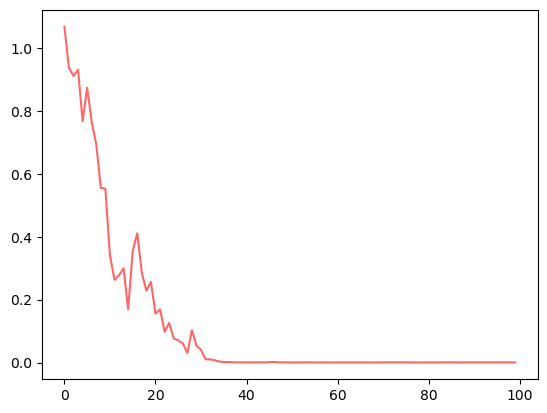

In [52]:
import matplotlib.pyplot as plt

plt.plot(losses, color="#FF6666")

In [53]:
dropout_lock = False
calculate_accuarcy(qmodel, X_test, y_test)

array([98.84495112,  7.72904039, 59.73806529,  5.98712102,  0.25568722])

In [53]:
# array([98.87070045,  7.63037941, 58.22268997,  5.85365099,  0.43295637])

### - save the model

In [157]:
with open('loss/angle/loss5.pkl', 'wb') as pkl_file:
    pickle.dump(losses, pkl_file)

In [156]:
average_accuracy = np.mean([
    0.9842, 0.9850, 0.9837, 0.9858, 0.9852
])
average_accuracy

0.98478

### - describe trained model

In [381]:
qmodel

QModel(
  (qlstm): StackedQLSTM(
    (qlstms): Sequential(
      (QGRU 1): QGRU(
        (update_circuit): QuantumLayer(
          (qin): Linear(in_features=44, out_features=5, bias=True)
          (qout): Linear(in_features=5, out_features=32, bias=True)
        )
        (candidate_circuit): QuantumLayer(
          (qin): Linear(in_features=44, out_features=4, bias=True)
          (qout): Linear(in_features=4, out_features=32, bias=True)
        )
        (reset_circuit): QuantumLayer(
          (qin): Linear(in_features=44, out_features=3, bias=True)
          (qout): Linear(in_features=3, out_features=32, bias=True)
        )
      )
      (QGRU 2): QGRU(
        (update_circuit): QuantumLayer(
          (qin): Linear(in_features=64, out_features=5, bias=True)
          (qout): Linear(in_features=5, out_features=32, bias=True)
        )
        (candidate_circuit): QuantumLayer(
          (qin): Linear(in_features=64, out_features=4, bias=True)
          (qout): Linear(in_features=

In [379]:
trainable = 0
for p in qmodel.parameters():
    if p.requires_grad:
        trainable += p.numel()
print(f'total parameters: {trainable}')

qlstm = QLSTMMap.get(qmodel.mode)[1]
print(f'quantum paramers: {qlstm(1, 1, ctx = ctx).qparameters_size}')

total parameters: 2544
quantum paramers: 66


### - Save the Model

In [152]:
# save the model
torch.save(qmodel.state_dict(), "model/angle_adjusted.pt")

In [60]:
results = []

for i in range(0, len(X_test), features_size):
    input_data = X_test[i:i+1]
    result = qmodel(input_data)
    result = test_scaler.inverse_transform(result.data)
    
    results.append(result[0])

test1 = pd.DataFrame(test, columns=('meantemp',))
test2 = pd.DataFrame(test, columns=('humidity',))
test3 = pd.DataFrame(test, columns=('wind_speed',))
test4 = pd.DataFrame(test, columns=('meanpressure',))
results = pd.DataFrame(results)
results.columns = ('meantemp', 'humidity', 'wind_speed', 'meanpressure')
result1 = pd.DataFrame(results, columns=('meantemp', 'humidity', 'wind_speed'))
result2 = pd.DataFrame(results, columns=('meanpressure',))

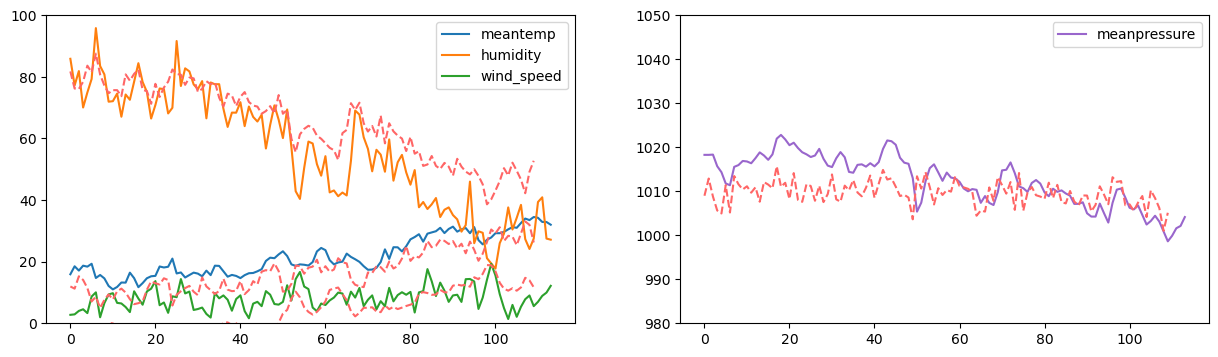

In [61]:
plt.figure(figsize=(15, 4))
plt.subplot(1,2,1)
plt.plot(test1, label="meantemp")
plt.plot(test2, label="humidity")
plt.plot(test3, label="wind_speed")

# plt.subplot(1,2,2)
plt.ylim(0, 100)
plt.plot(result1, color="#FF6666", linestyle="--")
plt.legend()

# plt.subplot(1,2,1)
plt.subplot(1,2,2)
plt.plot(test4, label="meanpressure", color="#9966CC")
plt.ylim(980, 1050)
plt.plot(result2, color="#FF6666", linestyle='--')

plt.legend()